# Multi-dimensional deconvolution - step-by-step guide

### Author: M.Ravasi

Many processing step in the seismic processing chain lend naturally to the creation and solution of large scale systems of equations. 

One of the most common building blocks of wave-equation-based processing of seismic data is the so-called multi-dimensional convolution (MDC) operator. Such an operator underlies some of the most common algorithms such SRME, IME and interferometry by multi-dimensional deconvolution (MDD) and Marchenko-based redatuming. 

In this notebook I will show you how to use the **MDC** linear operator of *Pylops* and its usage in the problem of **Multi-dimensional deconvolution (MDD)**.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.solver import cgls

## Multi-dimensional convolution (MDC)

The so-called multi-dimensional convolution (MDC) is a chained operator. It is composed of a forward Fourier transform a multi-dimensional integration (as shown in equation below) and an inverse Fourier transform:
    
$$ d(s,v,f) = \int_S R(s,r,f) m(v,r,f) dr$$

This operation can be discretized and performed by means of a linear operator

$$\mathbf{G}= \mathbf{F}^H  \mathbf{R} \mathbf{F}$$

where $\mathbf{F}$ is the Fourier transform applied along the time axis  and $\mathbf{R}$ is multi-dimensional convolution kernel espressed in the equation above.

Let's start considering a single virtual source

In [2]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]


# Create taper for operator
tap = taper3d(par['nt'], [par['ny'], par['nx']], [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G,Gwav = np.zeros((par['ny'],par['nx'],par['nt'])), np.zeros((par['ny'],par['nx'],par['nt']))
for iy,y0 in enumerate(y):
    G[iy],Gwav[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G,Gwav = G*tap,Gwav*tap

# Add negative part to operator and model
m     = np.concatenate((np.zeros((par['nx'], par['nt']-1)), m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

In [3]:
# Create frequency domain operator
Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

# Create operator
MDCop=MDC(Gwav_fft.transpose(2,0,1), nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=0, verb=True)

# Create data
d = MDCop*m.T.flatten()
#d = MDCop*mwav.T.flatten()
d = d.reshape(2*par['nt']-1, par['ny'])

Dot test passed, v^T(Opu)=484.487224 - u^T(Op^Tv)=484.487224


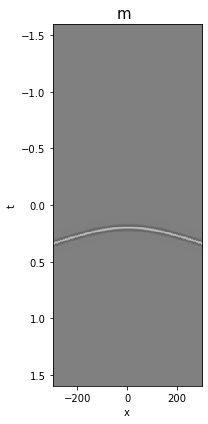

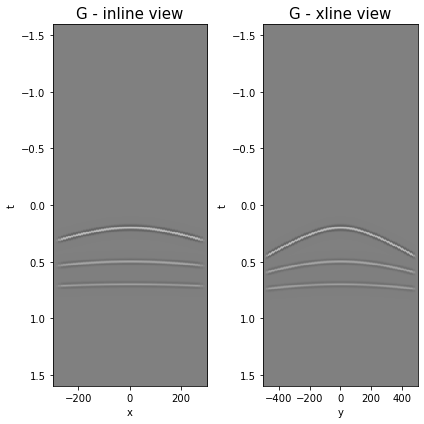

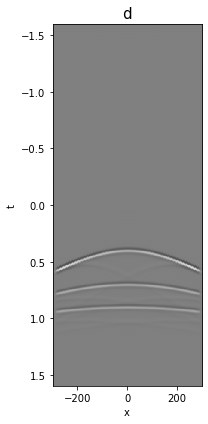

In [4]:
# Plotting
plt.figure(figsize=(3, 6))
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x')
plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(3, 6))
plt.imshow(d, aspect='auto',interpolation='nearest', vmin=-20, vmax=20, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

## Multi-dimensional deconvolution (MDD)

MDD is an ill-solved problem, well-known in the image processing and geophysical community. It aims to remove the effect of the multidimensional convolution kernel or the so-called point-spread function (PSF). It can be written as

$$\mathbf{d}= \mathbf{D} \mathbf{m}$$

or, equivalently, by means of its normal equation

$$\mathbf{m}= (\mathbf{D}^H\mathbf{D})^{-1} \mathbf{D}^H\mathbf{d}$$

where $\mathbf{D}^H\mathbf{D}$ is generally referred to as blurring operator or PSF.

### Single virtual source

Let's take from where we left and invert our MDC operator. This is done directly using the LSQR solver

In [5]:
madj = MDCop.H*d.flatten()

niter = 50
minv, istop, itn, r1norm, r2norm = lsqr(MDCop, d.ravel(), damp=1e-10, iter_lim=niter, show=1)[0:5]

madj = madj.reshape(2*par['nt']-1, par['nx'])
minv = minv.reshape(2*par['nt']-1, par['nx'])

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 80699 rows and 48739 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.836e+02  2.836e+02    1.0e+00  4.6e-01
     1  0.00000e+00   1.840e+02  1.840e+02    6.5e-01  6.8e-01   1.7e+02  1.0e+00
     2  0.00000e+00   1.267e+02  1.267e+02    4.5e-01  4.2e-01   2.5e+02  2.4e+00
     3  0.00000e+00   9.672e+01  9.672e+01    3.4e-01  2.9e-01   3.2e+02  3.8e+00
     4  0.00000e+00   7.788e+01  7.788e+01    2.7e-01  2.2e-01   3.7e+02  5.4e+00
     5  0.00000e+00   6.362e+01  6.362e+01    2.2e-01  1.9e-01   4.1e+02  7.2e+00
     6  0.00000e+00   5.448e+01  5.448e+01    1.9e-01  1.6e-01   4.5e+02  9.0e+00
     7  0.00000e+00   4.695e+01  4.695e+01    1.7e-01  1.3e-01   4.8e+02  1.1e+01
     8  0.00000e+00   4.039e+01 

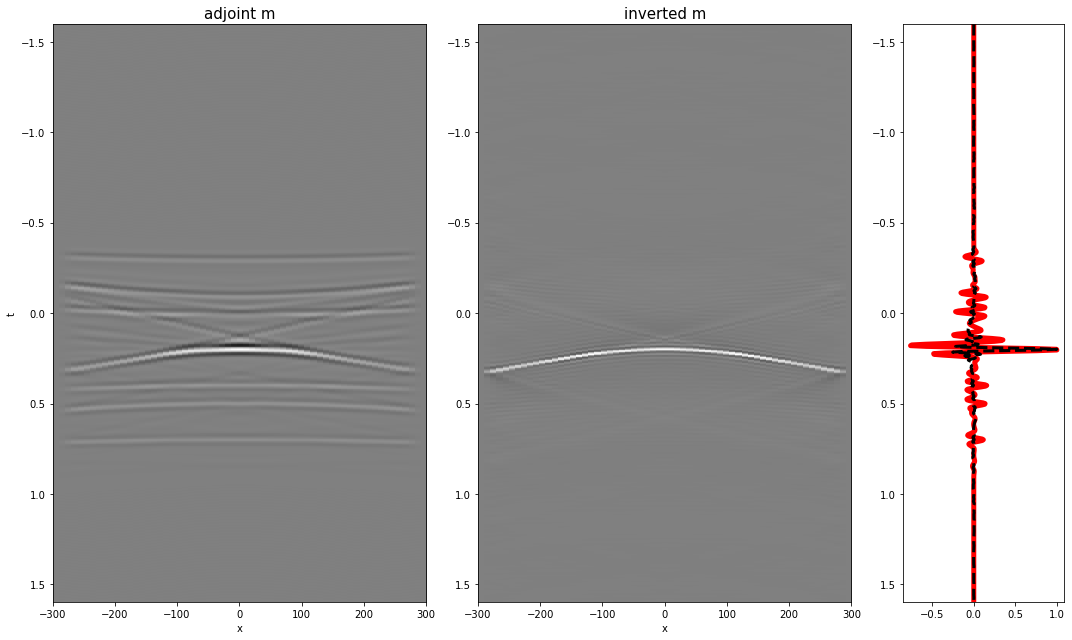

In [6]:
# Plotting
fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj, aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[:, int(par['nx']/2)]/np.abs(madj[:, int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[:, int(par['nx']/2)]/np.abs(minv[:, int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

In [7]:
# CGLS (to be able to track the norm)
def errnorm(m, mtrue, enorm):
    enorm.append(np.linalg.norm(m/m.max() - mtrue/mtrue.max()))
    
enorm = []
minv, istop, itn, r1norm, r2norm, cost = \
    cgls(MDCop, d.ravel(), np.zeros_like(m).ravel(), damp=1e-10, niter=niter, show=1, 
         callback=lambda x: errnorm(x, m.T.ravel(), enorm))

madj = madj.reshape(2*par['nt']-1, par['nx'])
minv = minv.reshape(2*par['nt']-1, par['nx'])

CGLS
-----------------------------------------------------------
The Operator Op has 80699 rows and 48739 cols
damp = 1.000000e-10	tol = 1.000000e-04	niter = 50
-----------------------------------------------------------
    Itn           x[0]              r1norm          r2norm
     1         0.0000e+00         1.8400e+02      1.8400e+02
     2         0.0000e+00         1.2667e+02      1.2667e+02
     3         0.0000e+00         9.6717e+01      9.6717e+01
     4         0.0000e+00         7.7877e+01      7.7877e+01
     5         0.0000e+00         6.3622e+01      6.3622e+01
     6         0.0000e+00         5.4483e+01      5.4483e+01
     7         0.0000e+00         4.6945e+01      4.6945e+01
     8         0.0000e+00         4.0387e+01      4.0387e+01
     9         0.0000e+00         3.5677e+01      3.5677e+01
    10         0.0000e+00         3.2002e+01      3.2002e+01
    20         0.0000e+00         1.4790e+01      1.4790e+01
    30         0.0000e+00         9.3478e+00     

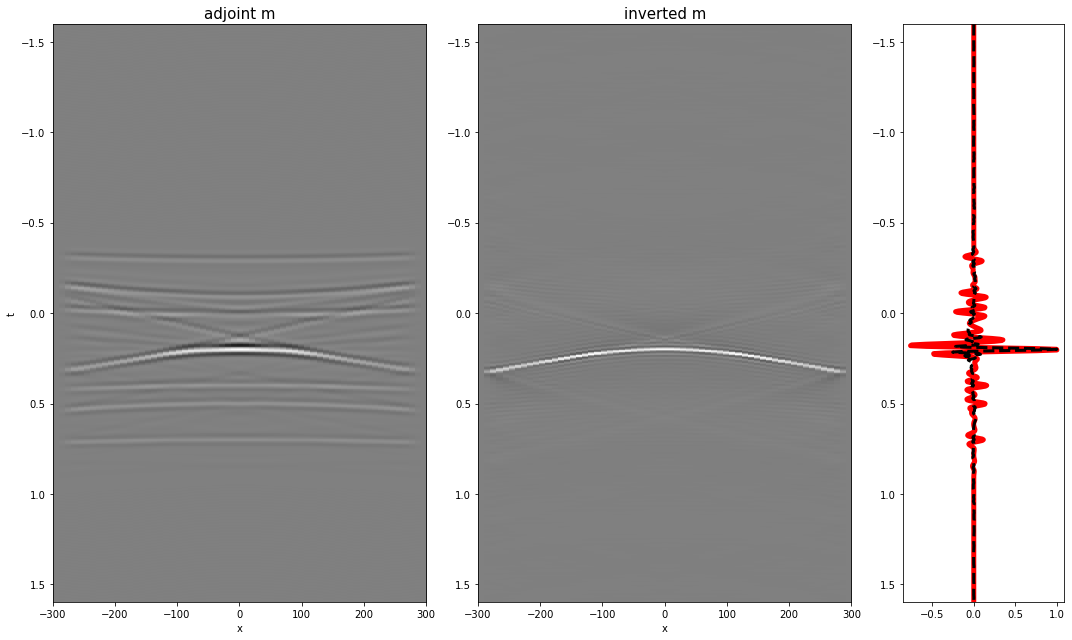

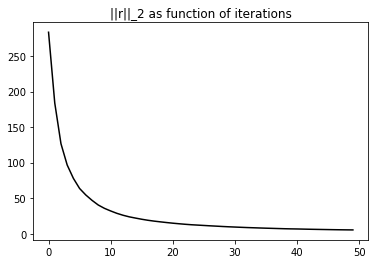

In [8]:
# Plotting
fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj, aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[:, int(par['nx']/2)]/np.abs(madj[:, int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[:, int(par['nx']/2)]/np.abs(minv[:, int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

plt.figure()
plt.plot(np.arange(niter), cost, 'k')
plt.title('||r||_2 as function of iterations');

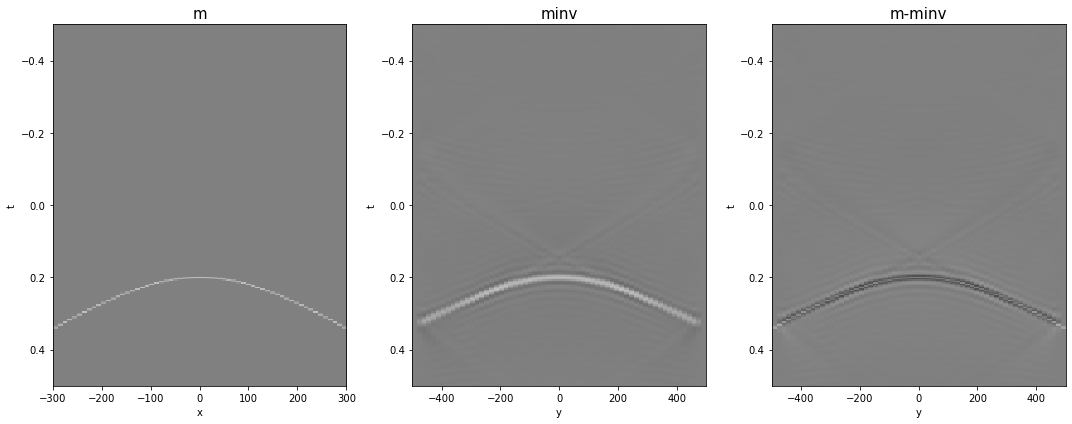

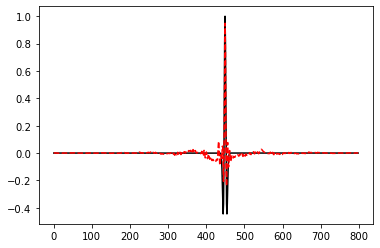

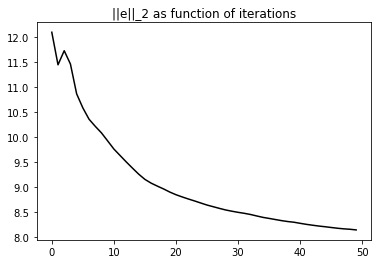

In [9]:
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.imshow(m.T / m.max(),aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.ylim(0.5, -0.5)
plt.subplot(132)
plt.imshow(minv / minv.max(),aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('minv', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.ylim(0.5, -0.5)
plt.subplot(133)
plt.imshow(m.T / m.max() - minv / minv.max(),aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('m-minv', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.ylim(0.5, -0.5)
plt.tight_layout()

plt.figure()
plt.plot(mwav[par['nx']//2]/ m.max(), 'k')
plt.plot(minv[:, par['nx']//2]/ minv.max(), '--r')

plt.figure()
plt.plot(np.arange(niter), enorm, 'k')
plt.title('||e||_2 as function of iterations');

Rescale cost and norm to match those used in Pytorch

In [10]:
cost = cost**2 / (d.size *par['ny'])

In [11]:
cost[0], np.sum(np.abs(d.ravel())**2)/ (d.size *par['ny'])

(0.009864619761154856, 0.009864619761154856)

In [12]:
np.linalg.norm(m/m.max())

6.531103548491797

In [13]:
np.savez('MDD_basic_norms.npz', minv=minv, cost=cost, enorm=enorm)

f = np.load('MDD_basic_norms.npz')
cost = f['cost']
enorm = f['enorm']